In [1]:
import numpy as np
import scipy.integrate as si
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
N = 1001
l = 10
xvec, dx = np.linspace(-l, l, N, retstep=True)
print(dx)
print(dx - (xvec[1] - xvec[0]))

0.02
4.2674197509029455e-16


(200,)
0.07522111306183957


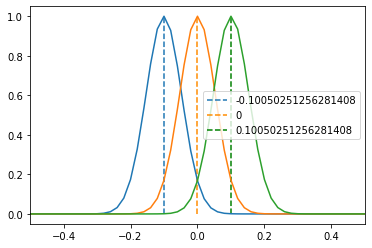

In [133]:
# test of overlap


# set the number of Gaussians we use as bases
Ng = 200 # 101 # 40

# make real space grid where each point
# is the location one of the Gaussian basis
# is centered around
xx, gx = np.linspace(-l, l, Ng, retstep=True)
print(xx.shape)

# set overlap
# this should insure that regardless of how many bases
# we use the overlate will be about the same
# fracmax sets at what fraction of the maximum hight
# we want our basis Gaussians to overlap
fracmax = 0.80
sigma = gx / (2 * np.sqrt(2 * np.log(1/fracmax) ) ) 
print(sigma)

# define Gaussian basis functions
def gauss(x, j):
    return np.exp(-((x - j*gx)/sigma)**2)

# plot the result
plt.plot(xvec, gauss(xvec,-1))
plt.vlines(-1*gx, ymin=0, ymax=1, label=-1*gx, linestyles='dashed')
plt.plot(xvec, gauss(xvec,0))
plt.vlines(0, ymin=0, ymax=1, label=0, color='darkorange', linestyles='dashed')
plt.plot(xvec, gauss(xvec,1))
plt.vlines(gx, ymin=0, ymax=1, label=gx, color='green', linestyles='dashed')
plt.xlim([-0.5,0.5])
plt.legend()
plt.show()

In [134]:
# - we want a SQUARE matrix where each row is one of the
# Gaussian basis functions sampled at the space points
# where the Gaussians basis functions are centered
# - the matrix must be square so we can use numpy.linalg.inv()
# or numpy.linalg.solv()
# - using broadcasting, we only need to expand one of the arrays
# so that np.exp(-(xx - np.expand_dims(xx,1))**2 / sigma)
# ends up with dimensions (Ng, Ng)
gmat = np.exp(-0.5*((xx - np.expand_dims(xx,1))/sigma)**2)
print(gmat.shape)

# this relates to how difficult it will be to invert
# gmat, a bigger number = harder to invert
np.linalg.cond(gmat)

(200, 200)


7.931728348975364

In [135]:
Nfine = N*2
xvecfine, dxfine = np.linspace(-l, l, Nfine, retstep=True)
# gmatplot = np.exp(-(np.expand_dims(xx,0) - np.expand_dims(xvec,1))**2 / sigma)
gmatplot = np.exp(-0.5*((xx - np.expand_dims(xvecfine, 1))/sigma)**2)
print(gmatplot.shape)

(2002, 200)


In [136]:
def myfunc(x):
    # out = (x < -3)*(x+3)**3/350 + ((x >= -3) & (x < 6))*(np.exp(-x - 3) - 1) + (x >= 6)*(np.exp(-9) - 1 + (x-6)**2/14)
    out = 2*np.cos(x) + np.sin(5*x)
    # harmonic potential
    # out = 0.5 * x**2
    # double well potential
    # out = 0.5 * (x**2 - 4)**2
    # soft Coulomb
    # out = 1 / np.sqrt(1 + (x - 10)**2)
    return out

In [137]:
# this gives us the coefficents which solve
# gmat @ coefs = myfunc(xx)
coefs = np.linalg.inv(gmat) @ myfunc(xx)
print(coefs.shape)

(200,)


In [138]:
#coefs

0.003513810937955251


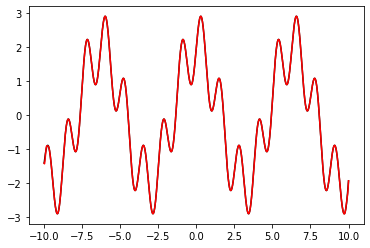

In [139]:
myfuncapprox = gmatplot @ coefs

print(dxfine*np.linalg.norm(myfunc(xvecfine) - myfuncapprox))

plt.plot(xvecfine, myfunc(xvecfine), '-', color='black')

plt.plot(xvecfine, myfuncapprox, '-', color='red')
plt.show()

<h3>Potential Operator for Gaussian Basis Model</h3>

In [145]:
hstart = 350
def vhfn(h):
    k = np.pi * h / l
    return np.sqrt(np.pi) * sigma * np.exp(-(k**2) * sigma**2) * (coefs * np.exp(-1j* np.expand_dims( k, axis=1) * xx)).sum(axis=1) / (2 * l)

vhprct = vhfn(np.arange(hstart, hstart+20))

In [146]:
print(vhprct.shape)
print(vhprct)

(20,)
[-2.03701364e-32+3.10862148e-33j  1.36958640e-32-2.15032136e-33j
 -9.19865422e-33+1.48711236e-33j  6.17151546e-33-1.02829269e-33j
 -4.13604157e-33+7.10971757e-34j  2.76882743e-33-4.91567925e-34j
 -1.85146960e-33+3.39896496e-34j  1.23662513e-33-2.35061895e-34j
 -8.24993632e-34+1.62605570e-34j  5.49722417e-34-1.12527126e-34j
 -3.65851412e-34+7.79122058e-35j  2.43176267e-34-5.39816694e-35j
 -1.61427631e-34+3.74330902e-35j  1.07018256e-34-2.59849408e-35j
 -7.08503250e-35+1.80612345e-35j  4.68389959e-35-1.25734406e-35j
 -3.09192733e-35+8.76972927e-36j  2.03787166e-35-6.13079884e-36j
 -1.34095667e-35+4.29791315e-36j  8.80847790e-36-3.02320427e-36j]


In [147]:
vhcalc = np.zeros(20, dtype=np.complex128)

for h in range(hstart, hstart+20):
    
    total = 0
    
    for j in range(Ng):
        def thisgauss(x):
            return np.exp(-((x - xx[j])/sigma)**2)
        
        def ahfn(x):
            theta = np.pi * h * x / l
            return np.cos(theta) * thisgauss(x)

        def bhfn(x):
            theta = np.pi * h * x / l
            return np.sin(theta) * thisgauss(x)

        ah = (1 / l) * si.quad(ahfn, a=-l, b=l)[0]

        if h >= 1:
            bh = (1 / l) * si.quad(bhfn, a=-l, b=l)[0]
        else:
            bh = 0
    
        total += coefs[j] * l * (ah - 1j*bh)
    
    vhcalc[h-hstart] = total / (2 * l)

In [148]:
print(vhcalc.shape)
print(vhcalc)

(20,)
[ 3.71376301e-05-0.00012694j -3.69335898e-05+0.00012659j
  3.67322663e-05-0.00012625j -3.65321416e-05+0.00012591j
  3.63340293e-05-0.00012557j -3.61357746e-05+0.00012524j
  3.59420845e-05-0.00012491j -3.57471166e-05+0.00012457j
  3.55546091e-05-0.00012424j -3.53647555e-05+0.00012391j
  3.51742241e-05-0.00012359j -3.49866425e-05+0.00012326j
  3.47999579e-05-0.00012294j -3.46147542e-05+0.00012261j
  3.44317948e-05-0.00012229j -3.42489345e-05+0.00012198j
  3.40685235e-05-0.00012166j -3.38888546e-05+0.00012134j
  3.37107808e-05-0.00012103j -3.35341290e-05+0.00012072j]


In [149]:
print(np.linalg.norm(vhprct - vhcalc))
print(vhprct - vhcalc)

0.0005756954260551906
[-3.71376301e-05+0.00012694j  3.69335898e-05-0.00012659j
 -3.67322663e-05+0.00012625j  3.65321416e-05-0.00012591j
 -3.63340293e-05+0.00012557j  3.61357746e-05-0.00012524j
 -3.59420845e-05+0.00012491j  3.57471166e-05-0.00012457j
 -3.55546091e-05+0.00012424j  3.53647555e-05-0.00012391j
 -3.51742241e-05+0.00012359j  3.49866425e-05-0.00012326j
 -3.47999579e-05+0.00012294j  3.46147542e-05-0.00012261j
 -3.44317948e-05+0.00012229j  3.42489345e-05-0.00012198j
 -3.40685235e-05+0.00012166j  3.38888546e-05-0.00012134j
 -3.37107808e-05+0.00012103j  3.35341290e-05-0.00012072j]
